# FoNS Datathon 2021 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
train_descriptors = pd.read_csv("train_descriptors.csv")
train_mord3d = pd.read_csv("train_mord3d.csv")
train_morgan = pd.read_csv("train_morgan.csv")
train_rdk = pd.read_csv("train_rdk.csv")

train_crystals = pd.read_csv("train_crystals.csv")
train_distances = pd.read_csv("train_distances.csv")
train_centroid_distances = pd.read_csv("train_centroid_distances.csv")

In [6]:
test_descriptors = pd.read_csv("test_descriptors.csv")
test_mord3d = pd.read_csv("test_mord3d.csv")
test_morgan = pd.read_csv("test_morgan.csv")
test_rdk = pd.read_csv("test_rdk.csv")

#### Data pre-processing

In [7]:
train_descriptors_full = train_descriptors.iloc[:, 3:-2].dropna(axis= 1, how="any")
train_descriptors_full.shape

(13449, 984)

In [305]:
test_descriptors_full = test_descriptors[train_descriptors_full.columns]
test_descriptors_full.shape

(3363, 984)

In [17]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(train_descriptors_full, train_crystals, test_size=0.2, random_state=47)

In [10]:
X_train3, X_val3, y_train3, y_val3 = model_selection.train_test_split(train_descriptors_full, train_centroid_distances, test_size=0.2, random_state=47)

In [328]:
X_train4, X_val4, y_train4, y_val4 = model_selection.train_test_split(train_descriptors_full, train_distances, test_size=0.2, random_state=47)

In [269]:
train_PCA = decomposition.PCA(n_components=0.95)
scaler_for_PCA = preprocessing.StandardScaler()
X_trainPCA = train_PCA.fit_transform(scaler_for_PCA.fit_transform(X_train))
X_valPCA = train_PCA.transform(scaler_for_PCA.transform(X_val))
print(X_trainPCA.shape, X_valPCA.shape)

(10759, 123) (2690, 123)


#### T4

In [329]:
train_PCA = decomposition.PCA(n_components=0.95)
scaler_for_PCA = preprocessing.StandardScaler()
X_trainPCA = train_PCA.fit_transform(scaler_for_PCA.fit_transform(X_train4))
X_valPCA = train_PCA.transform(scaler_for_PCA.transform(X_val4))
print(X_trainPCA.shape, X_valPCA.shape)

(10759, 123) (2690, 123)


In [331]:
M1=svm.SVR()
M1.fit(X_trainPCA,y_train4.n_vdw_contacts)

SVR()

In [348]:
M1Predictions=M1.predict(X_trainPCA)
M1MAE=metrics.mean_absolute_error(y_train4.n_vdw_contacts,M1Predictions)

In [333]:
metrics.mean_absolute_error(y_train4.n_vdw_contacts,M1.predict(X_trainPCA))

3.747496479376554

In [349]:
M1MAE

3.747496479376554

In [357]:
model3 = linear_model.LinearRegression()
model3.fit(X_train4, y_train4[target])

LinearRegression()

In [359]:
m3 = model3.predict(test_descriptors_full)

In [362]:
np.savetxt("task_4_predictions.csv", m3, delimiter=",")

#### T1 upload

In [321]:
target = "calculated_density"
model1u = svm.SVR()
model1u.fit(train_descriptors_full, train_crystals[target])
#m1upred = model1u.predict(X_val3)
#metrics.mean_absolute_error(y_val[target], m1pred)

SVR()

In [323]:
metrics.mean_absolute_error(train_crystals[target], m1upred)

0.05446367097204109

In [325]:
m1upred = model1u.predict(test_descriptors_full)

In [327]:
np.savetxt("task_1_predictions.csv", m1upred, delimiter=",")

In [338]:
target = "packing_coefficient"
model1u = svm.SVR()
model1u.fit(train_descriptors_full, train_crystals[target])
#m1upred = model1u.predict(X_val3)
#metrics.mean_absolute_error(y_val[target], m1pred)

SVR()

In [346]:
m1upred = model1u.predict(test_descriptors_full)

In [342]:
m1upred.shape

(3363,)

In [343]:
train_crystals[target].shape

(13449,)

In [345]:
metrics.mean_absolute_error(train_crystals[target], m1upred)

0.029897423264469383

In [347]:
np.savetxt("bonus_1_predictions.csv", m1upred, delimiter=",")

#### T2 upload

In [314]:
nntestpred = modelnn.predict(test_descriptors_PCA)

In [315]:
nntestpred = np.argmax(nntestpred, axis=1)

In [319]:
nntpbool = nntestpred.astype(np.bool)

In [320]:
np.savetxt("task_2_predictions.csv", nntpbool, delimiter=",")

In [310]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


modelnn = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l2(1e-3), input_shape=(124,)),
        Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(1e-3)),
        Dense(2, activation='sigmoid')
    ])

from sklearn.metrics import f1_score
#tf.keras.optimizers.SGD(learning_rate=0.0001)
modelnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#modelnn.summary()
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=100, monitor='loss')
train_data = tf.data.Dataset.from_tensor_slices((train_descriptors_PCA, train_crystals['is_centrosymmetric'].astype(np.int8)))
train_data = train_data.batch(4096)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

#val_data = tf.data.Dataset.from_tensor_slices((X_valPCA, y_val['is_centrosymmetric'].astype(np.int8)))
#val_data = val_data.batch(4096)
'''
train_data.element_spec
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train['is_centrosymmetric'].astype(np.int8)))
train_data = train_data.batch(128)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val['is_centrosymmetric'].astype(np.int8)))
val_data = val_data.batch(128)
, callbacks=[early_stopping]

'''
train_data.element_spec
history = modelnn.fit(train_data, epochs=400, callbacks=[early_stopping])


Epoch 1/400
4/4 [==============================] - 0s 8ms/step - loss: 1.8131 - accuracy: 0.6299
Epoch 2/400
4/4 [==============================] - 0s 8ms/step - loss: 1.6415 - accuracy: 0.8038
Epoch 3/400
4/4 [==============================] - 0s 9ms/step - loss: 1.5900 - accuracy: 0.8038
Epoch 4/400
4/4 [==============================] - 0s 7ms/step - loss: 1.5432 - accuracy: 0.8039
Epoch 5/400
4/4 [==============================] - 0s 9ms/step - loss: 1.4879 - accuracy: 0.8039
Epoch 6/400
4/4 [==============================] - 0s 8ms/step - loss: 1.4400 - accuracy: 0.8039
Epoch 7/400
4/4 [==============================] - 0s 7ms/step - loss: 1.3946 - accuracy: 0.8039
Epoch 8/400
4/4 [==============================] - 0s 7ms/step - loss: 1.3493 - accuracy: 0.8039
Epoch 9/400
4/4 [==============================] - 0s 8ms/step - loss: 1.3078 - accuracy: 0.8039
Epoch 10/400
4/4 [==============================] - 0s 7ms/step - loss: 1.2649 - accuracy: 0.8039
Epoch 11/400
4/4 [===========

#### Task 2 f1=0.69

In [277]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


modelnn = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l2(1e-3), input_shape=(123,)),
        Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(1e-3)),
        Dense(2, activation='sigmoid')
    ])

In [278]:
from sklearn.metrics import f1_score

In [279]:
tf.keras.optimizers.SGD(learning_rate=0.0001)

In [280]:
modelnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [293]:
#modelnn.summary()
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=80, monitor='val_accuracy')

In [294]:
train_data = tf.data.Dataset.from_tensor_slices((X_trainPCA, y_train['is_centrosymmetric'].astype(np.int8)))
train_data = train_data.batch(4096)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_valPCA, y_val['is_centrosymmetric'].astype(np.int8)))
val_data = val_data.batch(4096)

train_data.element_spec

(TensorSpec(shape=(None, 123), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int8, name=None))

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train['is_centrosymmetric'].astype(np.int8)))
train_data = train_data.batch(128)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val['is_centrosymmetric'].astype(np.int8)))
val_data = val_data.batch(128)

train_data.element_spec

In [295]:
history = modelnn.fit(train_data, epochs=400, validation_data=val_data, callbacks=[early_stopping])

Epoch 1/400
3/3 [==============================] - 0s 13ms/step - loss: 0.1050 - accuracy: 0.9847 - val_loss: 1.1419 - val_accuracy: 0.8033
Epoch 2/400
3/3 [==============================] - 0s 19ms/step - loss: 0.1044 - accuracy: 0.9832 - val_loss: 1.1266 - val_accuracy: 0.8071
Epoch 3/400
3/3 [==============================] - 0s 13ms/step - loss: 0.1053 - accuracy: 0.9830 - val_loss: 1.1349 - val_accuracy: 0.8100
Epoch 4/400
3/3 [==============================] - 0s 13ms/step - loss: 0.1063 - accuracy: 0.9827 - val_loss: 1.1193 - val_accuracy: 0.8052
Epoch 5/400
3/3 [==============================] - 0s 13ms/step - loss: 0.1031 - accuracy: 0.9838 - val_loss: 1.1104 - val_accuracy: 0.8030
Epoch 6/400
3/3 [==============================] - 0s 12ms/step - loss: 0.1062 - accuracy: 0.9833 - val_loss: 1.1242 - val_accuracy: 0.8156
Epoch 7/400
3/3 [==============================] - 0s 13ms/step - loss: 0.1046 - accuracy: 0.9830 - val_loss: 1.0976 - val_accuracy: 0.8074
Epoch 8/400
3/3 [===

In [296]:
nnpred = modelnn.predict(X_valPCA)

In [297]:
nnpred

array([[4.3844117e-05, 7.9021066e-01],
       [6.8743728e-05, 8.7970209e-01],
       [7.8223593e-04, 3.4458843e-01],
       ...,
       [3.4615706e-04, 7.1292901e-01],
       [2.0891430e-05, 9.4478148e-01],
       [2.3981953e-01, 4.2287954e-03]], dtype=float32)

In [298]:
nnpred1 = np.argmax(nnpred, axis=1)

In [299]:
np.mean(nnpred1 == y_val["is_centrosymmetric"].astype(np.int8))

0.8137546468401488

In [300]:
metrics.f1_score(y_val["is_centrosymmetric"], nnpred1, average='macro')

0.6821290178475607

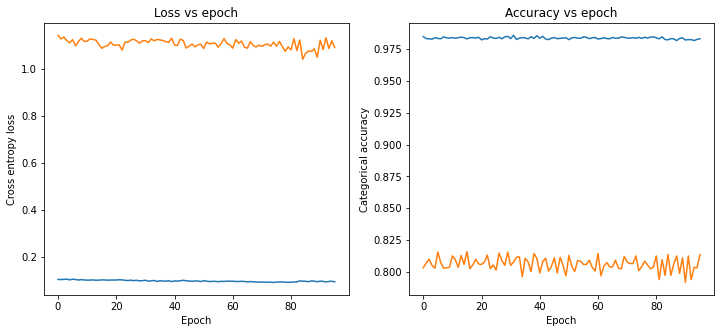

In [301]:


# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")

plt.show()



#### Task 1 SVR MAE=0.0577

In [66]:
target = "calculated_density"
model1 = svm.SVR()
model1.fit(X_train, y_train[target])

SVR()

In [67]:
m1pred = model1.predict(X_val3)

In [68]:
metrics.mean_absolute_error(y_val[target], m1pred)

0.05768788700937748

#### Task 3 LinReg mae=0.305 lasso_mae=0.2735 ridge_mae=0.266

In [351]:
target = "mean"
model3 = linear_model.Ridge(0.7)
model3.fit(X_train3, y_train3[target])

Ridge(alpha=0.7)

In [353]:
target = "mean"
model3 = linear_model.Ridge(0.7)
model3.fit(train_descriptors_full, train_centroid_distances[target])

Ridge(alpha=0.7)

In [355]:
m3pred = model3.predict(test_descriptors_full)

In [62]:
metrics.mean_absolute_error(y_val3[target], m3pred)

0.2660196799269595

In [58]:
mae3 = []
for i in np.logspace(-3, 0):
    model3 = linear_model.Ridge(i)
    model3.fit(X_train3, y_train3[target])
    m3pred = model3.predict(X_val3)
    mae3i = metrics.mean_absolute_error(y_val3[target], m3pred)
    mae3.append(mae3i)

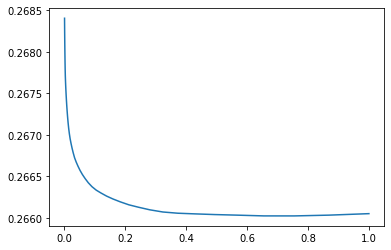

In [59]:
plt.plot(np.logspace(-3, 0),mae3)

In [ ]:
np.savetxt("task_3_predictions.csv", m3pred, delimiter=",")

#### Task 3 SVR MAE=0.29

In [63]:
target = "mean"
model3 = svm.SVR()
model3.fit(X_train3, y_train3[target])

SVR()

In [64]:
m3pred = model3.predict(X_val3)

In [65]:
metrics.mean_absolute_error(y_val3[target], m3pred)

0.2915383303558062

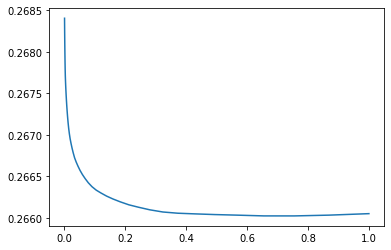

In [ ]:
plt.plot(np.logspace(-3, 0),mae3)

#### Task 2 SVC accu=0.81 f1=0.53

In [30]:
clf = pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC(gamma='auto'))
clf.fit(X_train, y_train["is_centrosymmetric"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [33]:
clfxpred = clf.predict(X_val)

In [34]:
np.mean(clfxpred == y_val["is_centrosymmetric"])

0.8156133828996283

In [40]:
metrics.f1_score(y_val["is_centrosymmetric"], clfxpred, average='macro')

0.5306737805693091